In [1]:
# loading modules for creating models (Tensorflow/Keras Framework)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import datetime
import pathlib

print("modules loaded successfully")
print(f"Tensorflow Version : {tf.__version__}")

modules loaded successfully
Tensorflow Version : 2.17.0


In [2]:
# Raw Dataset Directory
train_data_dir = pathlib.Path("../data/train_set")
test_data_dir = pathlib.Path("../data/test_set")

# Getting a count of images in both train and test set
train_image_count = len(list(train_data_dir.glob("*/*.jpg")))
test_image_count = len(list(test_data_dir.glob("*/*.jpg")))

print(f"train size : {train_image_count}")
print(f"test size : {test_image_count}\n")


# class names in dataset
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
print(CLASS_NAMES,"\n")

# obtain number of classes
num_classes = len(CLASS_NAMES)
print(f"Number of classes : {num_classes}")

train size : 819
test size : 212

['BA- cellulitis' 'BA-impetigo' 'FU-athlete-foot' 'FU-nail-fungus'
 'FU-ringworm' 'PA-cutaneous-larva-migrans' 'VI-chickenpox' 'VI-shingles'] 

Number of classes : 8


In [3]:
# Generating data from ImageGenerator function in preprocessing class of tensorflow, data pulled from Kaggle for auxillary training

# Shape inputs of neural net model
BATCH_SIZE =32 # Used for better utilization of memory

def data_generator(directory, aug : bool = True, height : int =227, width : int =227, batch_size : int=32):
    """
    Generates image datasets for input into a Neural Network model. If you are generating a training dataset, setting aug = True generates a dataset with 
    data augmentations implemented.

    Args:
        directory : source of image dataset
        aug (bool) : apply augmentations to the dataset if you are generating a training dataset
                        default is True
        height (int) : Height of image in pixels 
                        Default is 227
        width (int) : Width of image in pixels 
                        Default is 227
        BATCH_SIZE (int): A list of metrics to be evaluated by the model during training and testing. 
                        Default is 32.

    Returns:
            Tensorflow image dataset
    """

    # Instantiate ImageGenerator class with rescale parameter and apply augmentations
    if aug == True :

        # ImageGenerator class for generating trainig data
        image_generator = ImageDataGenerator(rescale = 1./255, # Normalize pixel values between 0 and 1
                                            vertical_flip = True, # Vertical transposition
                                            horizontal_flip = True, # Horizontal transpostion
                                            rotation_range = 90, # Random Rotations of 90 Degrees
                                            height_shift_range = 0.3, # Shift height of image by 30%
                                            brightness_range = [0.1, 0.9],
                                            validation_split = 0.15) # Specify range to increase and decrease brightness
        # ImageGenerator class for generating test data
    else :
        image_generator = ImageDataGenerator(rescale = 1./255,)
    
    data_gen = image_generator.flow_from_directory(directory=str(directory),
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    target_size = (height,width))

    return data_gen

# Generating test and train datasets using data_generator() function.
train_data_gen = data_generator(train_data_dir)
test_data_gen = data_generator(test_data_dir, aug=False)

Found 924 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


In [4]:
# Experiment 1 : Creating an alex net model from scratch to test performance on a blanket model (no pre-trained weights).
def create_alexnet(num_classes : int, loss_function="categorical_crossentropy", metrics : list = ['accuracy']) -> tf.keras.Model :
    
    """
    Creates a Convolutional Neural Network (CNN) model based on the AlexNet architecture, 
    with Batch Normalization layers for stabilizing the training. The model starts with an input
    image dimension of (227, 227, 3) and progressively reduces the spatial dimensions while 
    increasing the number of filters in each Conv2D/MaxPooling block.

    Args:
        num_classes (int): The number of output classes for the classification task.
        loss_function (str or callable): The loss function to use during model compilation. 
                                        Default is 'categorical_crossentropy'.
        metrics (list): A list of metrics to be evaluated by the model during training and testing. 
                        Default is ['accuracy'].
        
    Returns:
        model (tf.keras.Model): A compiled CNN model with batch normalization, ready for training.
    
    Example:
        model = create_alexnet(10, loss_function='categorical_crossentropy')
        model.summary()
    """
    model = Sequential([

        # 1st convolutional-pooling block
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation="relu", input_shape=(227,227,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),

        # 2nd convolutional-pooling block
        Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),

        # 3rd convolutional block
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
        BatchNormalization(),

        # Flatten layer to convert 3D feature map into 1D Vector to feed into Neural Network
        Flatten(),

        # Fully connected (dense) layers block with dropout regularization
        Dense(4096, activation="relu"),
        Dropout(0.5),
        Dense(4096, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=Adam(learning_rate = 0.0001), loss=loss_function, metrics=['accuracy'])

    return model

In [5]:
# Compile model for training
model_A = create_alexnet(num_classes=num_classes)
model_A.summary()

c:\Users\Rizwan\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    56,627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,637,000 (296.16 MB)

 Trainable params: 77,633,992 (296.15 MB)

 Non-trainable params: 3,008 (11.75 KB)

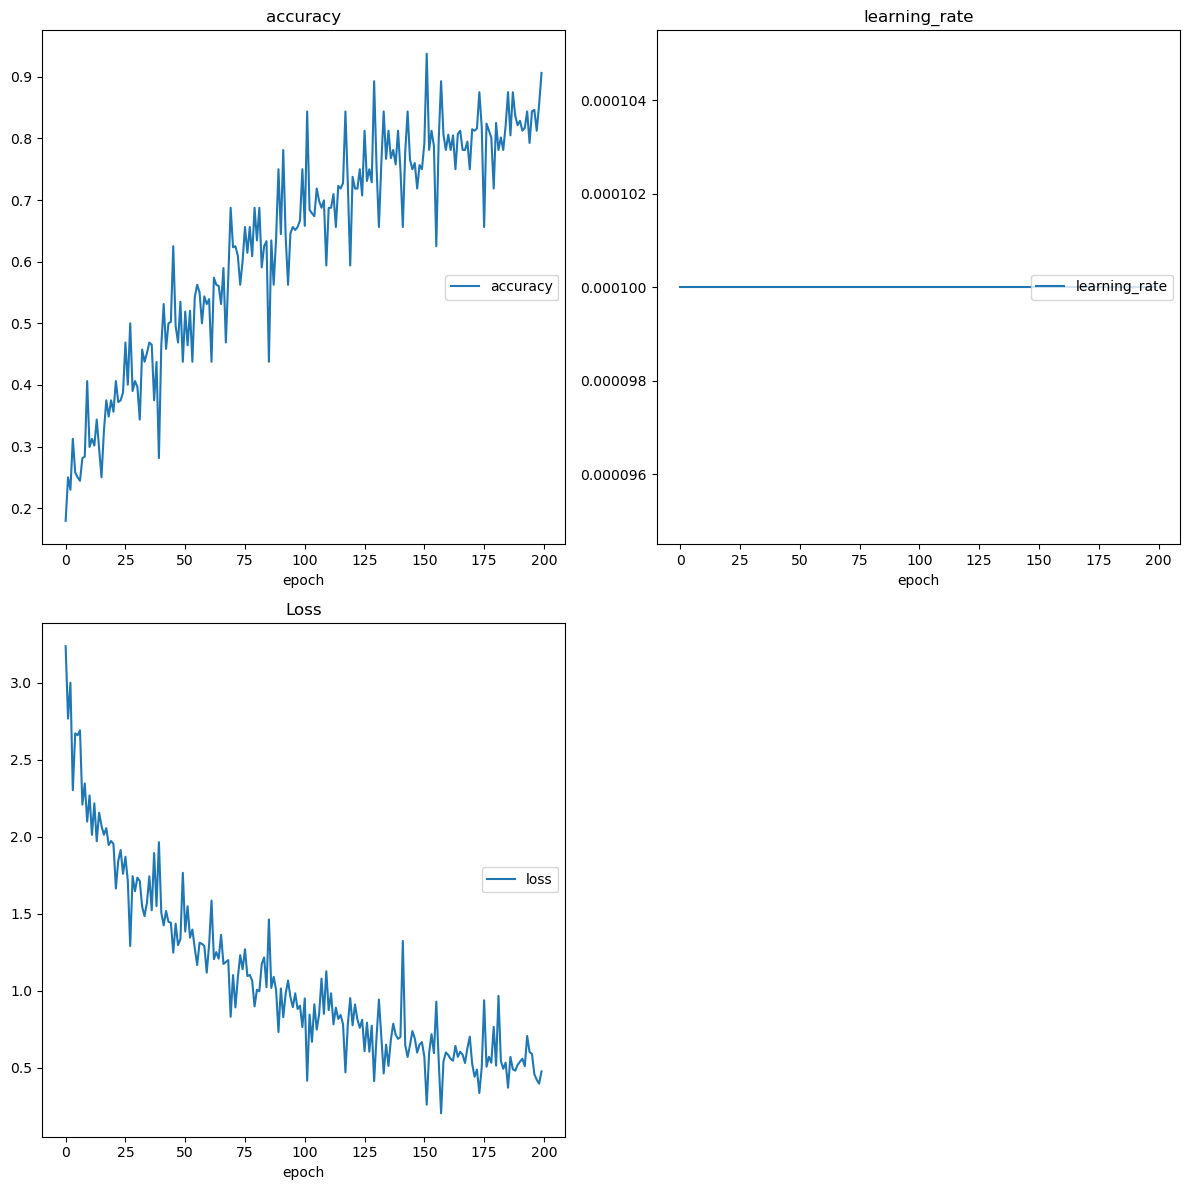

accuracy
	accuracy         	 (min:    0.179, max:    0.938, cur:    0.906)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.203, max:    3.236, cur:    0.476)
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9062 - loss: 0.4756 - learning_rate: 1.0000e-04


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

lr_scheduler = ReduceLROnPlateau(
    monitor = "Loss", # Monitor training loss
    factor = 0.1, # scale factor decrease learning rate by
    patience = 5, # Number of epochs to wait for change 
    min_lr = 1e-5 # Minimum learning rate
)

steps_per_epoch = train_data_gen.samples//BATCH_SIZE

n_epochs = 100

# Checkpointer saves model after each epoch
checkpointer = ModelCheckpoint(filepath="../models/model_A.weights.best.keras",
                                verbose = 1,
                                save_best_only = True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                            patience = 10,
                            restore_best_weights = True,
                            mode = 'min')

# Tensorboard
tb_callback = TensorBoard(log_dir="../models/model A/logs")

# Actual fitting on the model

history = model_A.fit(
    train_data_gen,
    steps_per_epoch = steps_per_epoch,
    epochs = 200,
    callbacks = [checkpointer, tb_callback, lr_scheduler, PlotLossesKeras()]
)

In [9]:
train_loss, train_accuracy = model_A.evaluate(train_data_gen)
test_loss, test_accuracy = model_A.evaluate(test_data_gen)

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.7274 - loss: 0.7982
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7638 - loss: 0.9877


In [10]:
print(f"train accuracy : {train_accuracy}, test accuracy : {test_accuracy}\n")
print(f"train loss : {train_loss}, test loss : {test_loss}\n")

train accuracy : 0.7316017150878906, test accracy : 0.7639485001564026

train accuracy : 0.7844730019569397, test loss : 1.0088757276535034



In [11]:
# Experiment 1 : Creating an alex net model from scratch to test performance on a blanket model (no pre-trained weights).
def create_alexnet_without_dropout(num_classes : int, loss_function="categorical_crossentropy", metrics : list = ['accuracy']) -> tf.keras.Model :
    
    """
    Creates a Convolutional Neural Network (CNN) model based on the AlexNet architecture, 
    with Batch Normalization layers for stabilizing the training. The model starts with an input
    image dimension of (227, 227, 3) and progressively reduces the spatial dimensions while 
    increasing the number of filters in each Conv2D/MaxPooling block. The difference now is that dropout is removed

    Args:
        num_classes (int): The number of output classes for the classification task.
        loss_function (str or callable): The loss function to use during model compilation. 
                                        Default is 'categorical_crossentropy'.
        metrics (list): A list of metrics to be evaluated by the model during training and testing. 
                        Default is ['accuracy'].
        
    Returns:
        model (tf.keras.Model): A compiled CNN model with batch normalization, ready for training.
    
    Example:
        model = create_alexnet(10, loss_function='categorical_crossentropy')
        model.summary()
    """
    model = Sequential([

        # 1st convolutional-pooling block
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation="relu", input_shape=(227,227,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),

        # 2nd convolutional-pooling block
        Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),

        # 3rd convolutional block
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same'),
        BatchNormalization(),

        # Flatten layer to convert 3D feature map into 1D Vector to feed into Neural Network
        Flatten(),

        # Fully connected (dense) layers block without dropout regularization
        Dense(4096, activation="relu"),
        Dense(4096, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=Adam(learning_rate = 0.0001), loss=loss_function, metrics=['accuracy'])

    return model

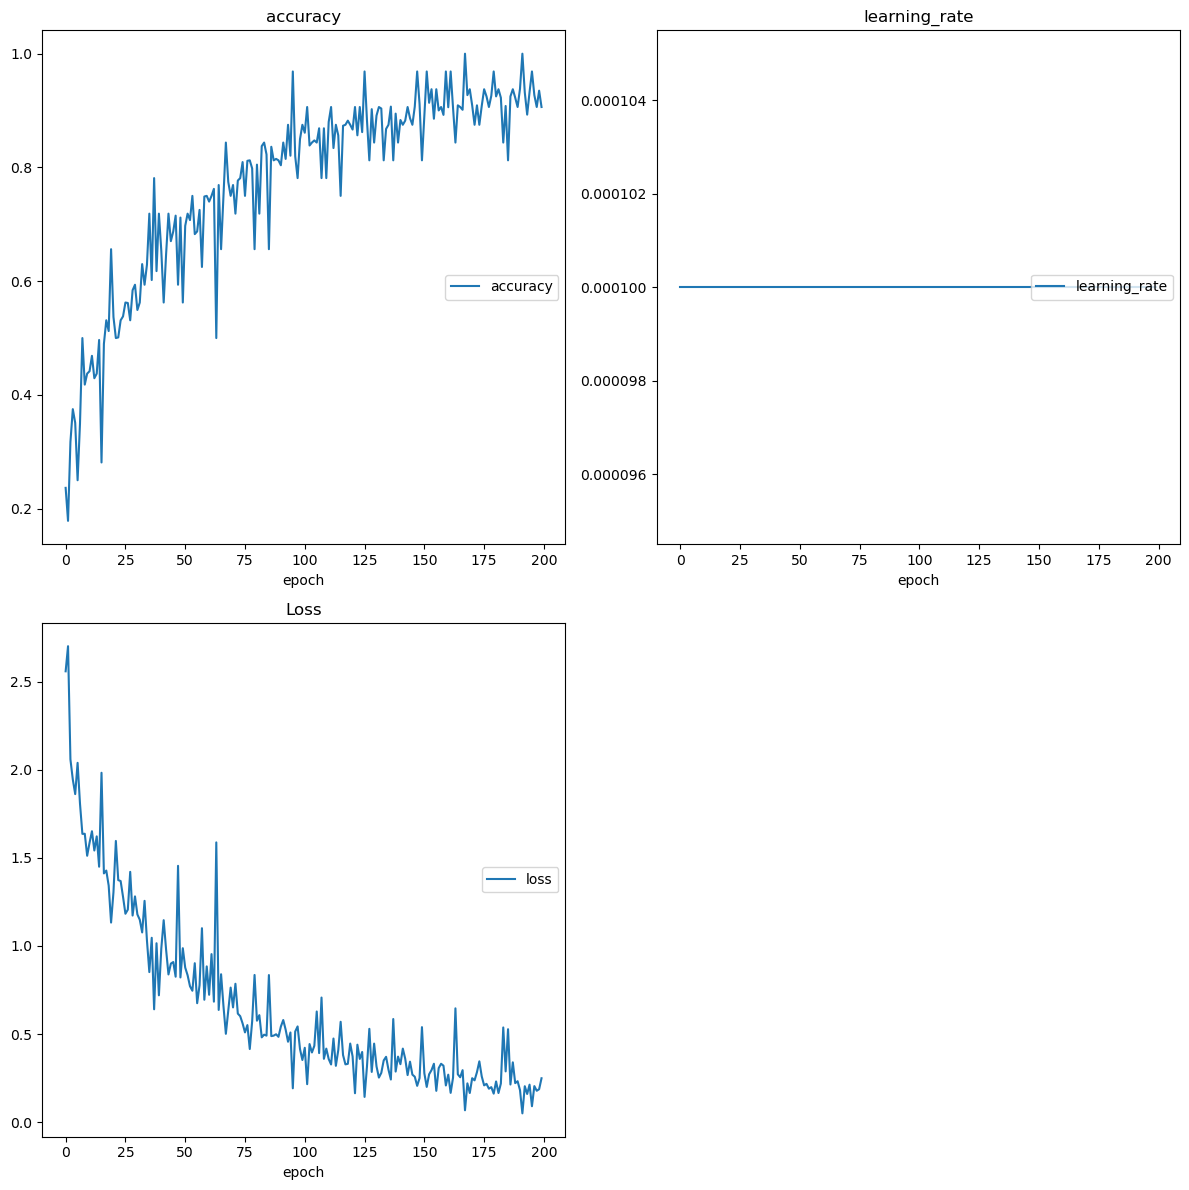

accuracy
	accuracy         	 (min:    0.179, max:    1.000, cur:    0.906)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.050, max:    2.700, cur:    0.250)
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9062 - loss: 0.2495 - learning_rate: 1.0000e-04


In [14]:
# Compile model for training
model_A2 = create_alexnet_without_dropout(num_classes=num_classes)
model_A2.summary()

#Fitting the new model to dataset
history_2 = model_A2.fit(
    train_data_gen,
    steps_per_epoch = steps_per_epoch,
    epochs = 200,
    callbacks = [checkpointer, tb_callback, lr_scheduler, PlotLossesKeras()]
)

In [18]:
train_loss2, train_accuracy2 = model_A2.evaluate(train_data_gen)
test_loss2, test_accuracy2 = model_A2.evaluate(test_data_gen)

print(f"train accuracy : {train_accuracy2}, test accuracy : {test_accuracy2}")
print(f"Train loss: {train_loss2}, test loss : {test_loss2}\n")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9216 - loss: 0.2243
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8814 - loss: 0.5865
train accuracy : 0.9285714030265808, test accuracy : 0.8841201663017273
Train loss: 0.2158772349357605, test loss : 0.6178902983665466

